Epoch [5/1000], Train Loss: 0.6199, Val Loss: 0.5919
Epoch [10/1000], Train Loss: 0.4153, Val Loss: 0.3630
Epoch [15/1000], Train Loss: 0.2021, Val Loss: 0.1759
Epoch [20/1000], Train Loss: 0.1329, Val Loss: 0.1243
Epoch [25/1000], Train Loss: 0.1122, Val Loss: 0.1029
Epoch [30/1000], Train Loss: 0.0955, Val Loss: 0.0872
Epoch [35/1000], Train Loss: 0.0812, Val Loss: 0.0764
Epoch [40/1000], Train Loss: 0.0746, Val Loss: 0.0701
Epoch [45/1000], Train Loss: 0.0647, Val Loss: 0.0599
Epoch [50/1000], Train Loss: 0.0558, Val Loss: 0.0519
Epoch [55/1000], Train Loss: 0.0458, Val Loss: 0.0438
Epoch [60/1000], Train Loss: 0.0380, Val Loss: 0.0371
Epoch [65/1000], Train Loss: 0.0319, Val Loss: 0.0318
Epoch [70/1000], Train Loss: 0.0277, Val Loss: 0.0283
Epoch [75/1000], Train Loss: 0.0245, Val Loss: 0.0259
Epoch [80/1000], Train Loss: 0.0223, Val Loss: 0.0243
Epoch [85/1000], Train Loss: 0.0206, Val Loss: 0.0230
Epoch [90/1000], Train Loss: 0.0192, Val Loss: 0.0222
Epoch [95/1000], Train Loss: 

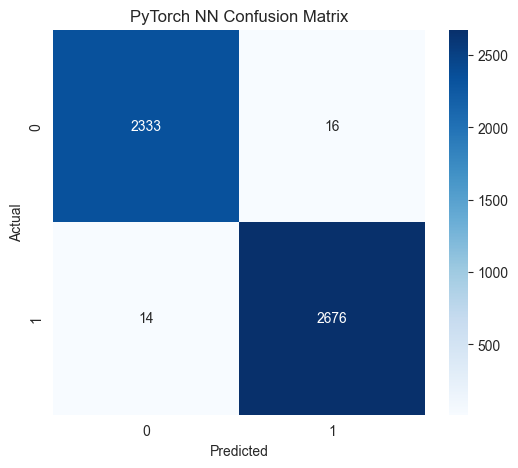

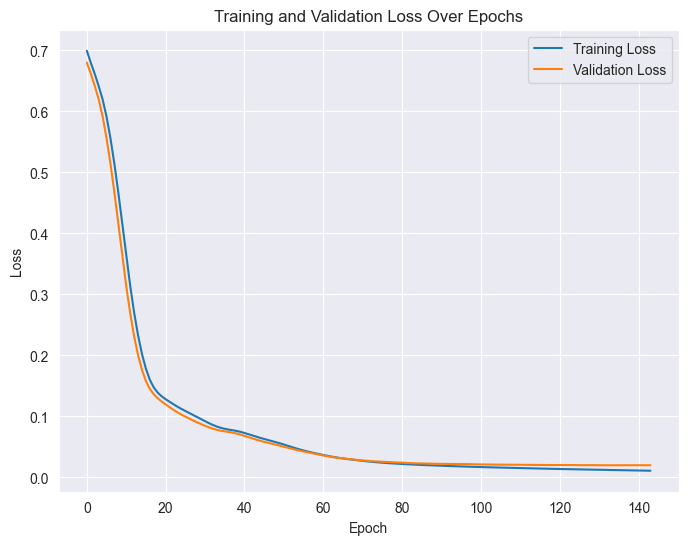

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

# Load data
file_path = "Data/Train_data.csv"
df = pd.read_csv(file_path)

# Encode categorical features
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Separate features and target
X = df.drop(columns='class')
y = df['class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data (using stratify if needed)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define Neural Network model
class IntrusionDetectionNN(nn.Module):
    def __init__(self, input_size):
        super(IntrusionDetectionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)  # Binary classification output
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Initialize model, loss, and optimizer
input_size = X_train_tensor.shape[1]
model = IntrusionDetectionNN(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Set training parameters including early stopping
epochs = 1000
patience = 10  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')
patience_counter = 0

# Lists to track loss over epochs
train_losses = []
val_losses = []

# Training loop with early stopping
for epoch in range(epochs):
    model.train()
    # Forward pass on training data
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Save training loss
    train_losses.append(train_loss.item())
    
    # Evaluate on validation (test) set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
    
    # Print losses every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    # Early stopping check: if validation loss improves, reset counter, else increase it.
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_test_bin = (y_pred_test > 0.5).float()

# Convert predictions for sklearn evaluation
y_pred_test_np = y_pred_test_bin.numpy()
y_test_np = y_test_tensor.numpy()

print("Neural Network Accuracy:", accuracy_score(y_test_np, y_pred_test_np))
print("Classification Report:\n", classification_report(y_test_np, y_pred_test_np))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_test_np)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("PyTorch NN Confusion Matrix")
plt.show()

# Plot training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()
